In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.display import display # Allows the use of display() for DataFrames
from time import time
import matplotlib.pyplot as plt
import seaborn as sns # Plotting library
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.python.keras.utils import np_utils
from sklearn.datasets import load_files   
from tqdm import tqdm
from collections import Counter

In [18]:
train_path = "./skin-lesions/train"
val_path = "./skin-lesions/valid"
test_path = "./skin-lesions/test"

In [19]:
def load_data_raw (path):
    data = load_files(path)
    files = np.array(data["filenames"])
    targets = np_utils.to_categorical(np.array(data["target"]), 3)
    
    return files, targets

train_filenames, train_targets = load_data_raw(train_path)

<BarContainer object of 3 artists>

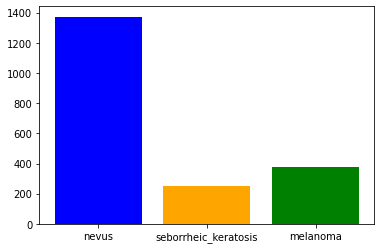

In [20]:
filenames_trimmed = [filename.split('/')[-2] for filename in train_filenames]
classes_count = Counter(filenames_trimmed)

# Plot the classes
plt.bar(classes_count.keys(), classes_count.values(), color=['blue', 'orange', 'green'])

In [21]:
def plot_n_samples(filenames):
    filenames_trimmed = [filename.split('/')[-2] for filename in filenames]
    classes_count = Counter(filenames_trimmed)

    # Plot the classes
    plt.bar(classes_count.keys(), classes_count.values(), color=['blue', 'orange', 'green'])

##### Unsampling function for imbalanced data

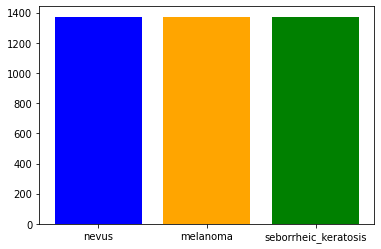

In [22]:
from sklearn.utils import resample, shuffle

# Choose one of the 3 for the feature_name
feature_names = {0: 'melanoma', 1: 'nevus', 2: 'seborrheic_keratosis'}

def upsample(filenames, targets, feature_name, n_samples = 1372):
    upsample_idx = []
    

    # Find all the indices for nevus
    for i, path in enumerate(filenames):
        # If feature matches, save the index
        if feature_name in path.split('/'):
            upsample_idx.append(i)
    
    # Remove selected features from filenames to add the upsampled after
    new_filenames = [filename for i, filename in enumerate(filenames) if i not in upsample_idx]
    new_targets = [target for i, target in enumerate(targets) if i not in upsample_idx]

    # Upsample
    resampled_x, resampled_y = resample(filenames[upsample_idx], targets[upsample_idx], n_samples=n_samples, random_state=0)

    # Add the upsampled features to new_filenames and new_targets
    new_filenames += list(resampled_x)
    new_targets += list(resampled_y) 
    
    return np.array(new_filenames), np.array(new_targets)
    
# We upsample twice: once for each feature we want upsampled
upsample_train_x, upsample_train_y = upsample(train_filenames, train_targets, feature_names[0])
upsample_train_x, upsample_train_y = upsample(upsample_train_x, upsample_train_y, feature_names[2])

plot_n_samples(upsample_train_x)

In [24]:
from tensorflow.keras.preprocessing import image   

# Convert the image paths to tensors Manually
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224,224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)


train_filenames = paths_to_tensor(upsample_train_x)
train_targets = upsample_train_y

100%|███████████████████████████████████████| 4116/4116 [06:38<00:00, 10.33it/s]


##### Load the data

In [25]:
batch_size=60

# Transforms
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1,  # randomly shift images horizontally 
    height_shift_range=0.1,  # randomly shift images vertically
    horizontal_flip=True)

datagen_valid = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1,  # randomly shift images vertically
    horizontal_flip=True)

datagen_test = ImageDataGenerator(
    rescale=1./255)

In [28]:
# Generators
'''
train_generator = datagen_train.flow_from_directory(
        data_train_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')
'''

train_generator = datagen_train.flow(train_filenames, train_targets, batch_size=batch_size)

valid_generator = datagen_valid.flow_from_directory(
        val_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

test_generator = datagen_test.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=1,
        class_mode='categorical',
        shuffle=False)

Found 150 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [29]:
num_train = len(train_filenames)
num_valid = len(valid_generator.filenames)
num_test = len(test_generator.filenames)

print(num_train, num_valid, num_test)

4116 150 600


In [32]:
# Class name to the index
#class_2_indices = train_generator.class_indices
class_2_indices = {'melanoma': 0, 'nevus': 1, 'seborrheic_keratoses': 2}
print("Class to index:", class_2_indices)

# Reverse dict with the class index to the class name
indices_2_class = {v: k for k, v in class_2_indices.items()}
print("Index to class:", indices_2_class)

Class to index: {'melanoma': 0, 'nevus': 1, 'seborrheic_keratoses': 2}
Index to class: {0: 'melanoma', 1: 'nevus', 2: 'seborrheic_keratoses'}


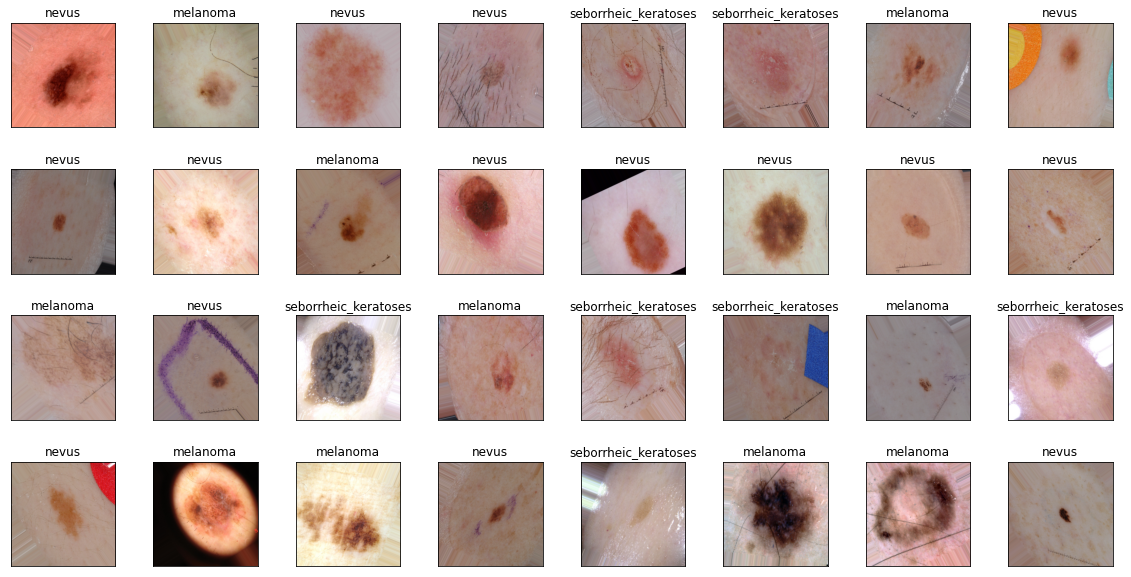

In [33]:
# Lets have a look at some of our images
images, labels = train_generator.next()

fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(wspace=0.2, hspace=0.4)

# Lets show the first 32 images of a batch
for i, img in enumerate(images[:32]):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(img)
    image_idx = np.argmax(labels[i])
    ax.set(title=indices_2_class[image_idx])

## Create the model

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50V2

from tensorflow.keras.models import Model

base_model = ResNet50V2(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = MaxAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation = 'elu')(x)
x = Dropout(0.3)(x)
# and a logistic layer
predictions = Dense(3, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = True

model.summary()

94674944/94668760 [==============================] - 11s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
__________________________

In [61]:
from tensorflow.keras.optimizers import Adam

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy',
             metrics=['accuracy'])

In [62]:
from sklearn.utils import class_weight

# Convert one hot encoded labels to ints
train_targets_classes = [np.argmax(label) for label in train_targets]

# Compute the weights
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(train_targets_classes),
                                                  y = train_targets_classes)

class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: 1.0, 1: 1.0, 2: 1.0}


In [63]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# train the model
checkpointer = ModelCheckpoint(filepath='aug_model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-8, verbose=1)

early_stopper = EarlyStopping(monitor='val_loss', patience=10,
                              verbose=0, restore_best_weights=True)

history = model.fit_generator(train_generator,
                    class_weight= class_weights_dict,
                    steps_per_epoch=num_train//batch_size,
                    epochs=40,
                    verbose=1,
                    callbacks=[checkpointer, scheduler, early_stopper],
                    validation_data=valid_generator,
                    validation_steps=num_valid//batch_size)

Epoch 1/40
67/68 [============================>.] - ETA: 50s - loss: 0.7430 - accuracy: 0.6699 
Epoch 00001: val_loss improved from inf to 0.97688, saving model to aug_model.weights.best.hdf5
68/68 [==============================] - 3449s 51s/step - loss: 0.7415 - accuracy: 0.6716 - val_loss: 0.9769 - val_accuracy: 0.6500
Epoch 2/40
67/68 [============================>.] - ETA: 49s - loss: 0.4311 - accuracy: 0.8213 
Epoch 00002: val_loss improved from 0.97688 to 0.95699, saving model to aug_model.weights.best.hdf5
68/68 [==============================] - 3409s 50s/step - loss: 0.4300 - accuracy: 0.8217 - val_loss: 0.9570 - val_accuracy: 0.7083
Epoch 3/40
67/68 [============================>.] - ETA: 49s - loss: 0.2795 - accuracy: 0.8936 
Epoch 00003: val_loss did not improve from 0.95699
68/68 [==============================] - 3394s 50s/step - loss: 0.2769 - accuracy: 0.8950 - val_loss: 1.0061 - val_accuracy: 0.7750
Epoch 4/40
67/68 [============================>.] - ETA: 49s - loss: 

## Test model

In [64]:
# load the weights that yielded the best validation accuracy
model.load_weights('aug_model.weights.best.hdf5')

In [65]:
score = model.evaluate_generator(test_generator, steps=num_test//1, verbose=1)
print('\n', 'Test accuracy:', score[1])

600/600 [==============================] - 270s 450ms/step - loss: 1.0926 - accuracy: 0.7717

 Test accuracy: 0.77166665


In [66]:
predictions = model.predict_generator(test_generator, steps=num_test)

task_1 = pd.DataFrame(data=[desease[0] for desease in predictions])
task_2 = pd.DataFrame(data=[desease[2] for desease in predictions])

##### RocAuc Score

In [70]:
from sklearn.metrics import roc_auc_score, accuracy_score

ground_truth = pd.read_csv("./dermatologist-ai/ground_truth.csv")
labels = np_utils.to_categorical(np.array(test_generator.classes), 3)

roc_auc_all = roc_auc_score(labels, predictions)
roc_auc_task_1 = roc_auc_score(ground_truth['task_1'], task_1)
roc_auc_task_2 = roc_auc_score(ground_truth['task_2'], task_2)

print('Roc auc score for all data is: {}'.format(roc_auc_all))
print('Roc auc score for task 1 is: {}'.format(roc_auc_task_1))
print('Roc auc score for task 2 is: {}'.format(roc_auc_task_2))

Roc auc score for all data is: 0.8384993995669304
Roc auc score for task 1 is: 0.7873511351772222
Roc auc score for task 2 is: 0.8893681917211329


In [72]:
test_filenames, test_targets = load_data_raw(test_path)

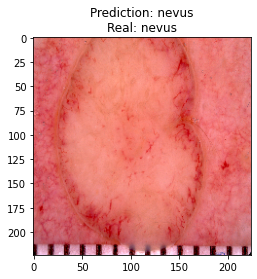

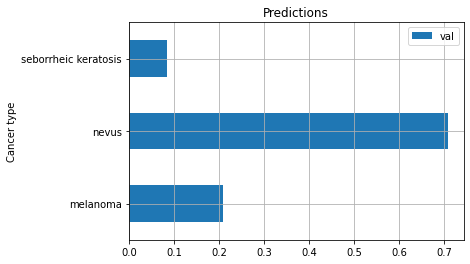

In [73]:
def plot_prediction(img_file, img_target):

    img = image.load_img(img_file, target_size=(224,224))
    img = image.img_to_array(img)/255
    img_expand = np.expand_dims(img, axis=0)
    
    # Make a prediction
    prediction = model.predict(img_expand, steps=1)
    image_idx = np.argmax(prediction[0])
    prediction_string = indices_2_class[image_idx]
    
    # Get the real label's name
    label_idx = np.argmax(img_target)
    real_label = indices_2_class[label_idx]
    
    # Plot predictions
    title = "Prediction: {}\nReal: {}".format(prediction_string, real_label)
    
    plt.imshow(img)
    plt.title(title)
    
    pred_df = pd.DataFrame({'Cancer type':['melanoma', 'nevus', 'seborrheic keratosis'], 'val':prediction[0]})
    ax = pred_df.plot.barh(x='Cancer type', y='val', title="Predictions", grid=True)
    
random_index = np.random.randint(0, len(test_generator.filenames))
plot_prediction(test_filenames[random_index], test_targets[random_index])

##### Performance curves

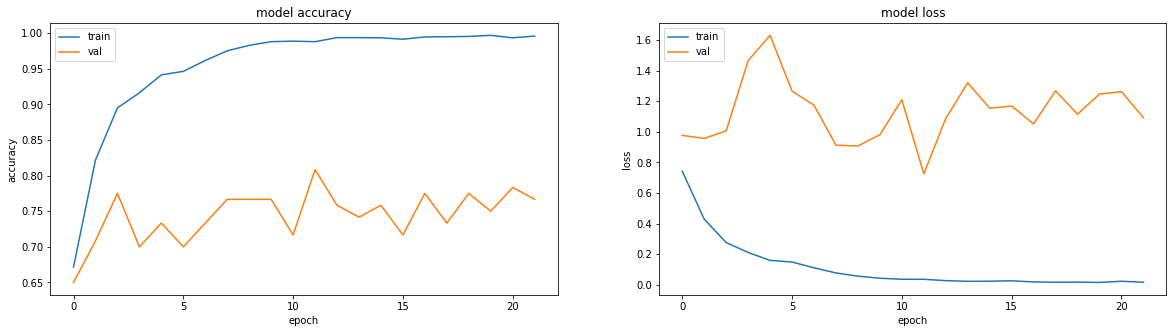

In [76]:
plts, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))

# summarize history for accuracy
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set(xlabel='epoch', ylabel='accuracy')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set(xlabel='epoch', ylabel='loss')
ax2.legend(['train', 'val'], loc='upper left')

[Text(0, 0.5, 'melanoma'), Text(0, 1.5, 'nevus'), Text(0, 2.5, 'keratoses')]

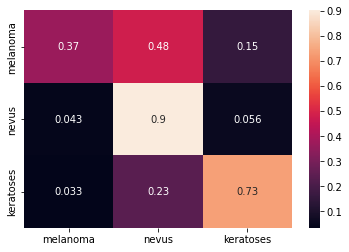

In [77]:
from sklearn.metrics import confusion_matrix

# Confusion matrix for all classes
y_true = test_generator.classes
y_pred = [np.argmax(x) for x in predictions]

labels = ["melanoma", "nevus", "keratoses"]
cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Normalize confusion matrix
ax = sns.heatmap(cm, annot=True)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

/Users/doukkim/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/doukkim/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


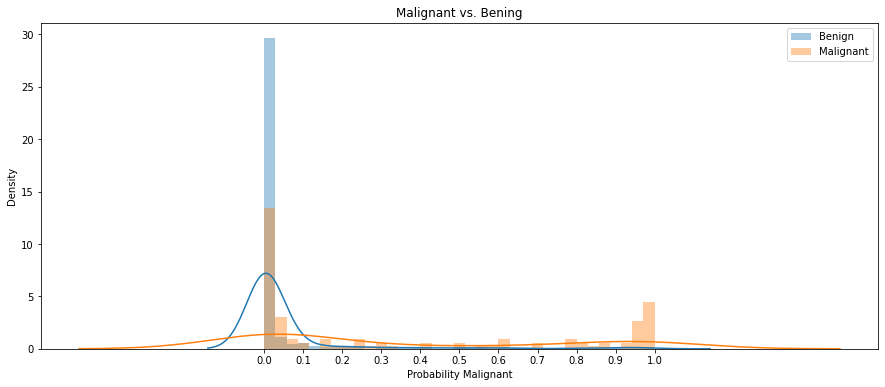

In [86]:
def plot_distribution(pred_target_y, filenames):
    melanoma_idx = []
      
    # Find all the indices for nevus
    for i, path in enumerate(filenames):
        # If feature matches, save the index
        if 'melanoma' in path.split('/'):
            melanoma_idx.append(i)
            
    bening_preds = [pred for i, pred in enumerate(pred_target_y) if i not in melanoma_idx]
    malignant_preds = [pred for i, pred in enumerate(pred_target_y) if i in melanoma_idx]
    
    fig, ax = plt.subplots(1,1,figsize=(15,6))
    
    ax.set_title('Malignant vs. Bening')
    sns.distplot(bening_preds, hist= True, kde=True, label="Benign", bins=35)
    sns.distplot(malignant_preds, hist= True, kde=True, label="Malignant", bins=35, axlabel="Probability Malignant")
    ax.legend()
    ax.xaxis.set_ticks(np.arange(0, 1.1, 0.1))

plot_distribution(task_1.values, test_generator.filenames)

In [88]:
from tensorflow.keras.applications.inception_v3 import InceptionV3 

base_model_02 = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model_02.output
x = GlobalAveragePooling2D()(x)
# x = MaxAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation = 'elu')(x)
x = Dropout(0.5)(x)
# and a logistic layer
predictions = Dense(3, activation='softmax')(x)

# this is the model we will train
model_02 = Model(inputs=base_model_02.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
for layer in base_model_02.layers:
    layer.trainable = True

model_02.summary()

87916544/87910968 [==============================] - 6s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
___________________________

In [89]:
model_02.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [91]:
# train the model
checkpointer = ModelCheckpoint(filepath='aug_model_02.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-8, verbose=1)

early_stopper = EarlyStopping(monitor='val_loss', patience=10,
                              verbose=0, restore_best_weights=True)

history = model_02.fit_generator(train_generator,
                    class_weight= class_weights_dict,
                    steps_per_epoch=num_train//batch_size,
                    epochs=40,
                    verbose=1,
                    callbacks=[checkpointer, scheduler, early_stopper],
                    validation_data=valid_generator,
                    validation_steps=num_valid//batch_size)

Epoch 1/40
67/68 [============================>.] - ETA: 37s - loss: 0.7713 - accuracy: 0.6474 
Epoch 00001: val_loss improved from inf to 1.13480, saving model to aug_model_02.weights.best.hdf5
68/68 [==============================] - 2601s 38s/step - loss: 0.7679 - accuracy: 0.6497 - val_loss: 1.1348 - val_accuracy: 0.5667
Epoch 2/40
67/68 [============================>.] - ETA: 37s - loss: 0.4241 - accuracy: 0.8311 
Epoch 00002: val_loss improved from 1.13480 to 0.94143, saving model to aug_model_02.weights.best.hdf5
68/68 [==============================] - 2573s 38s/step - loss: 0.4236 - accuracy: 0.8314 - val_loss: 0.9414 - val_accuracy: 0.6750
Epoch 3/40
67/68 [============================>.] - ETA: 35s - loss: 0.2744 - accuracy: 0.8956 
Epoch 00003: val_loss did not improve from 0.94143
68/68 [==============================] - 2440s 36s/step - loss: 0.2744 - accuracy: 0.8955 - val_loss: 0.9991 - val_accuracy: 0.7083
Epoch 4/40
67/68 [============================>.] - ETA: 35s - 

In [92]:
# load the weights that yielded the best validation accuracy
model_02.load_weights('aug_model_02.weights.best.hdf5')

In [93]:
score = model_02.evaluate_generator(test_generator, steps=num_test//1, verbose=1)
print('\n', 'Test accuracy:', score[1])

600/600 [==============================] - 282s 470ms/step - loss: 1.2665 - accuracy: 0.6900

 Test accuracy: 0.69


In [94]:
predictions = model_02.predict_generator(test_generator, steps=num_test)

task_1 = pd.DataFrame(data=[desease[0] for desease in predictions])
task_2 = pd.DataFrame(data=[desease[2] for desease in predictions])

In [95]:
ground_truth = pd.read_csv("./dermatologist-ai/ground_truth.csv")
labels = np_utils.to_categorical(np.array(test_generator.classes), 3)

roc_auc_all = roc_auc_score(labels, predictions)
roc_auc_task_1 = roc_auc_score(ground_truth['task_1'], task_1)
roc_auc_task_2 = roc_auc_score(ground_truth['task_2'], task_2)

print('Roc auc score for all data is: {}'.format(roc_auc_all))
print('Roc auc score for task 1 is: {}'.format(roc_auc_task_1))
print('Roc auc score for task 2 is: {}'.format(roc_auc_task_2))

Roc auc score for all data is: 0.8333520278643047
Roc auc score for task 1 is: 0.777299994691299
Roc auc score for task 2 is: 0.90880174291939


In [96]:
test_filenames, test_targets = load_data_raw(test_path)

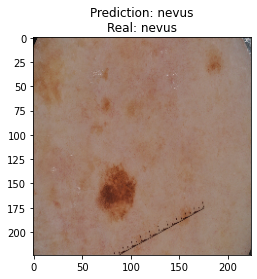

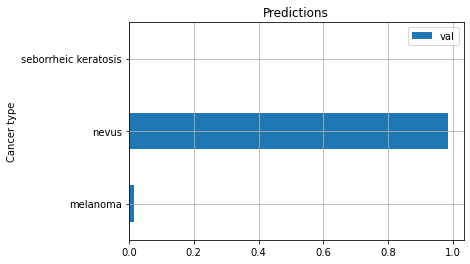

In [97]:
random_index = np.random.randint(0, len(test_generator.filenames))
plot_prediction(test_filenames[random_index], test_targets[random_index])

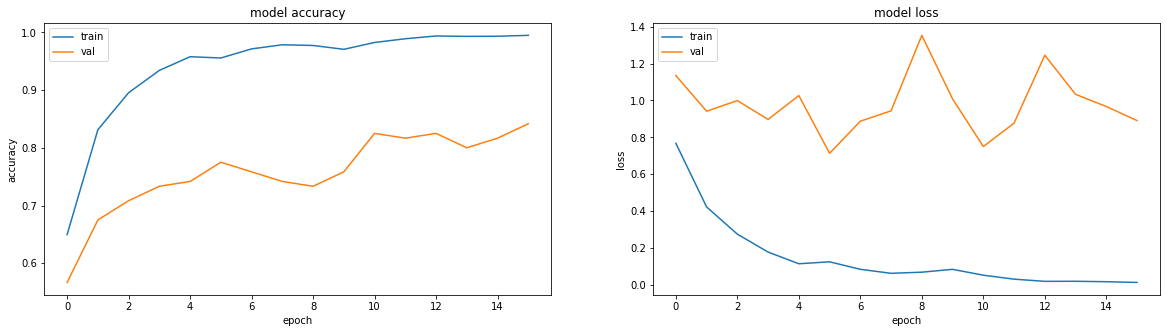

In [100]:
plts, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))

# summarize history for accuracy
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set(xlabel='epoch', ylabel='accuracy')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set(xlabel='epoch', ylabel='loss')
ax2.legend(['train', 'val'], loc='upper left')

[Text(0, 0.5, 'melanoma'), Text(0, 1.5, 'nevus'), Text(0, 2.5, 'keratoses')]

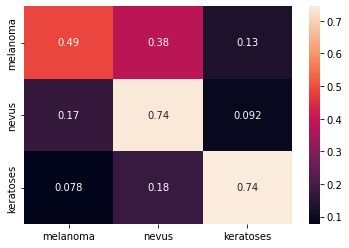

In [101]:
from sklearn.metrics import confusion_matrix

# Confusion matrix for all classes
y_true = test_generator.classes
y_pred = [np.argmax(x) for x in predictions]

labels = ["melanoma", "nevus", "keratoses"]
cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Normalize confusion matrix
ax = sns.heatmap(cm, annot=True)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)